## Dynamic Movement Primitives (DMP) + Gaussian Mixture Regression (GMR)

In [1]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm as normal_dist
from mixture_model import *
from plot_utils import *
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In this demo, we model the letter movement data as Dynamic Movement Primitives. The movement of each variable ($x_1$,$x_2$) is modeled as a spring-damper system, disturbed with nonlinear forcing terms. We learn these forcing terms from the data by using GMR. While LWR only predicts a specific output value, GMR can provide the output distribution 

#### Load Data 

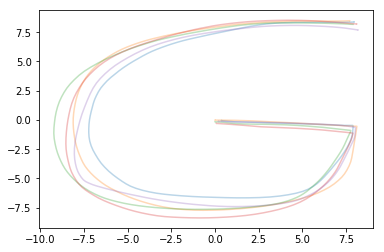

In [48]:
n_samples = 5 #number of demonstrations

ROOT = '../python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]
data = data.transpose([0,2,1])

#plot the data
for data_i in data:
    plt.plot(data_i[:,0], data_i[:,1],'-', alpha=0.3)

### Declare Variables 

In [24]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#DMP Parameters
Kp = 50 #Stiffness Gain
Kv = np.sqrt(2*Kp) #Damping gain with ideal underdamped damping ratio
alpha = 1. #Decay factor
dt = 0.01 #Length of each trajectory
L = np.hstack([np.eye(n_out)*Kp, np.eye(n_out)*Kv]) #feedback terms
t_in = np.arange(0,n_data*dt,dt) #time 

pos_index = np.arange(0,n_out)
vel_index = np.arange(n_out,2*n_out)
acc_index = np.arange(2*n_out,3*n_out)

#### Compute the velocity and acceleration from the position 

In [6]:
pos_trajs = data.copy()
vel_trajs = np.gradient(pos_trajs, axis=1)/dt
acc_trajs = np.gradient(vel_trajs, axis=1)/dt

### Computing the decay terms 

In [7]:
s_in = np.zeros(n_data) #decay terms
s_in[0] = 1.
for i in range(1,n_data):
    s_in[i] = s_in[i-1] - alpha*s_in[i-1]*dt

### Setting the target

The target here is set as the last point of the demonstration

In [8]:
x_target = data[0][-1]

### Computing the forcing terms 

In [9]:
F = []
for i in range(n_samples):
    f = acc_trajs[i] - Kp*(x_target-pos_trajs[i]) + Kv*vel_trajs[i]
    f = np.divide(f,np.tile(s_in,(2,1)).T)
    F.append(f)
    
F = np.array(F)

### GMR for the forcing terms 

Given the decay variables $s$ and the forcing terms $F$, we want to approximate the mapping $f(s) = F$ by GMR.

#### Define the input and output 

In [21]:
#Option 1: set the input to 1
#X = np.tile(np.ones(n_data), (1,n_samples)).T
#Y = np.concatenate(F,axis=0)

#Option 2: set the input to s_in (the decay variables)
X = np.tile(s_in, (1,n_samples)).T
Y = np.concatenate(F,axis=0)

In [37]:
data_joint = np.concatenate([X,Y],axis=1)
D = data_joint.shape[1]
N = data_joint.shape[0]

#define the input and output dimensions indices in GMM using slice()
n_in = X.shape[1]
n_out = Y.shape[1]
dim_in = slice(0,n_in) #indices starting from 0 to n_in -1
dim_out = slice(n_in,n_in+n_out) #indices starting from n_in to n_in + n_out -1

#### Estimate GMM based on data_joint 

In [38]:
gmm = GMM(D=D,K=n_states,M=1,N=N)
gmm.fit(data_joint)
clear_output()

#### Given an input, compute the GMR prediction 

In [39]:
#Construct the GMR
gmr = GMR(gmm,dim_in = dim_in, dim_out = dim_out)

In [40]:
Y_preds = []
Covs = []
for s in s_in:
    y,cov = gmr.predict(s)
    Y_preds.append(y)
    Covs.append(cov)
    
Y_preds = np.array(Y_preds)
Covs = np.array(Covs)

#### Plot the prediction and the mixture components 

[0.5, 0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5, 0.5]


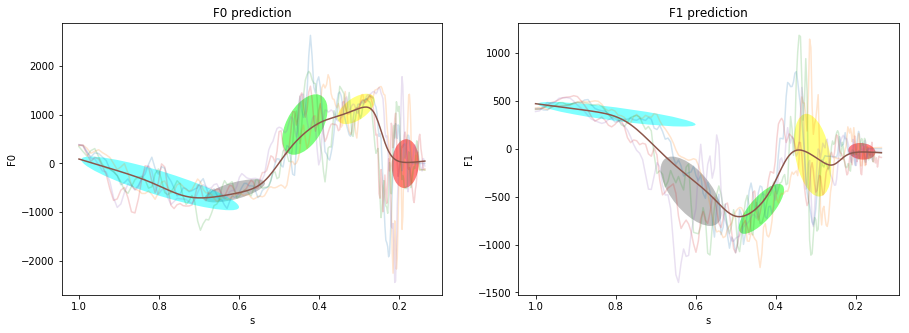

In [46]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)

ax[0].set_title('F0 prediction')
ax[0].set_xlabel('s')
ax[0].set_ylabel('F0')

ax[1].set_title('F1 prediction')
ax[1].set_xlabel('s')
ax[1].set_ylabel('F1')

#Plot the data
for i in range(n_samples):
    ax[0].plot(s_in, F[i,:,0], '-', alpha=0.2)
    ax[1].plot(s_in, F[i,:,1], '-', alpha=0.2)

#Plot the prediction
ax[0].plot(s_in, Y_preds[:,0])
ax[1].plot(s_in, Y_preds[:,1])

#Plot the mixture components
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]
f0_indices = slice(0,2)#indices for accessing (s,F0) in the gmm
f1_indices = slice(0,3,2)#indices for accessing (s,F1) in the gmm
plot_GMM(gmm.means_[:,f0_indices], gmm.covariances_[:,f0_indices,f0_indices],ax[0],colors=colors,alphas=[0.5]*n_states)
plot_GMM(gmm.means_[:,f1_indices], gmm.covariances_[:,f1_indices,f1_indices],ax[1],colors=colors,alphas=[0.5]*n_states)

#invert the axis because s starts from 1 and ends at 0
ax[0].invert_xaxis()
ax[1].invert_xaxis()

plt.show()

### Motion retrieval with DMP

Having obtained the forcing terms, we can retrieve the movement by computing the roll-out dynamics of the spring-damper system with the forcing terms.

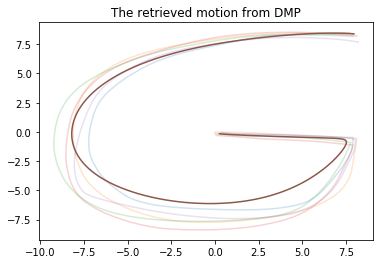

In [47]:
# Initial state
x = data[0,0,:]
dx = np.zeros((1,n_out))

#Compute the dynamics roll-out of the spring-damper system
x_traj = []
for t in range(n_data):
    ddx = Kp*(x_target-x) - Kv*dx + Y_preds[t,:]*s_in[t]
    dx = dx + ddx*dt
    x = x + dx*dt
    x_traj.append(x)

x_traj = np.concatenate(x_traj)


#Plot the resulting motion
for i in range(n_samples):
    plt.plot(data[i,:,0], data[i,:,1], alpha = 0.2)
    
plt.plot(x_traj[:,0], x_traj[:,1])
plt.title('The retrieved motion from DMP')
plt.show()
